In [21]:
# import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

cudnn.benchmark = True

In [22]:
# set seed for reproducibility
def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(282)

In [23]:
percent = 5
def important_row(saliency_maps_avg_a, quantile):
    x = saliency_maps_avg_a.mean(axis=1)
    pcen=np.percentile(x, quantile, interpolation='nearest')
    mask = np.where(x < pcen, 0, 1)
    return mask

mask_a = important_row(np.load('masks/saliency_maps_avg_a.npy'), quantile=percent)
# mask_a = torch.from_numpy(mask_a.astype(np.float32))
# mask_a = mask_a.unsqueeze(-1).expand(torch.Size([3, 192, 200]))

mask_i = important_row(np.load('masks/saliency_maps_avg_i.npy'), quantile=percent)
# mask_i = torch.from_numpy(mask_i.astype(np.float32))
# mask_i = mask_i.unsqueeze(-1).expand(torch.Size([3, 192, 200]))

mask_r = important_row(np.load('masks/saliency_maps_avg_r.npy'), quantile=percent)
# mask_r = torch.from_numpy(mask_r.astype(np.float32))
# mask_r = mask_r.unsqueeze(-1).expand(torch.Size([3, 192, 200]))

mask_s = important_row(np.load('masks/saliency_maps_avg_s.npy'), quantile=percent)
# mask_s = torch.from_numpy(mask_s.astype(np.float32))
# mask_s = mask_s.unsqueeze(-1).expand(torch.Size([3, 192, 200]))

uni_mask = mask_a + mask_i + mask_r + mask_s
uni_mask = uni_mask != 0
uni_mask = torch.from_numpy(uni_mask.astype(np.float32))
uni_mask = uni_mask.unsqueeze(-1).unsqueeze(0).unsqueeze(0).expand(torch.Size([4, 3, 192, 200]))
# print(uni_mask.shape)

/tmp/ipykernel_1913004/215662554.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  pcen=np.percentile(x, quantile, interpolation='nearest')


In [24]:
# prepare data
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../project/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# mask_a = mask_a.to(device)
# mask_i = mask_i.to(device)
# mask_r = mask_r.to(device)
# mask_s = mask_s.to(device)
uni_mask = uni_mask.to(device)

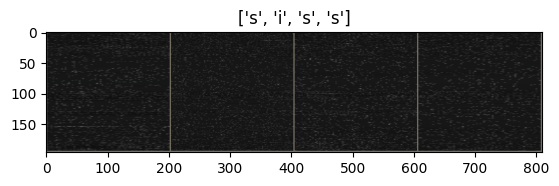

In [25]:
# visualize images before training
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
# print(inputs.shape)

In [26]:
# this is the train loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, use_mask=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if use_mask == True:
                    # new_inputs = []
                    # batch_label = [class_names[q] for q in labels]
                    # for num in range(len(batch_label)):
                    #     lbl = batch_label[num]
                    #     im = inputs[num]
                    #     if lbl == 'a':
                    #         # im = im * mask_a
                    #         idx = mask_a[0, :, 0]
                    #         im = im[:, idx != 0, :]
                    #     elif lbl == 'i':
                    #         # im = im * mask_i
                    #         idx = mask_i[0, :, 0]
                    #         im = im[:, idx != 0, :]
                    #     elif lbl == 'r':
                    #         # im = im * mask_r
                    #         idx = mask_r[0, :, 0]
                    #         im = im[:, idx != 0, :]
                    #     elif lbl == 's':
                    #         # im = im * mask_s
                    #         idx = mask_s[0, :, 0]
                    #         im = im[:, idx != 0, :]
                    #     new_inputs.append(im.unsqueeze(0))
                    # inputs = torch.concat(new_inputs, 0)
                        # inputs[num] = im
                        # print(inputs)
                    inputs = inputs * uni_mask

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    # save best model weights
    if use_mask == False:
        torch.save(best_model_wts, 'best_weights.pt')
    else:
        torch.save(best_model_wts, f'best_weights_masked_{str(int(percent))}.pt')
    return model

In [27]:
# visualize results after training
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'pre: {class_names[preds[j]]}, gt: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [28]:
# prepare parameters for model training
model_ft = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [29]:
# train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25, use_mask=True)

Epoch 0/24
----------
train Loss: 0.9555 Acc: 0.6202
val Loss: 0.6182 Acc: 0.7922

Epoch 1/24
----------
train Loss: 0.4882 Acc: 0.8248
val Loss: 0.3129 Acc: 0.9014

Epoch 2/24
----------
train Loss: 0.2697 Acc: 0.9049
val Loss: 0.2806 Acc: 0.9051

Epoch 3/24
----------
train Loss: 0.1809 Acc: 0.9382
val Loss: 0.1499 Acc: 0.9549

Epoch 4/24
----------
train Loss: 0.0992 Acc: 0.9686
val Loss: 0.1301 Acc: 0.9592

Epoch 5/24
----------
train Loss: 0.0627 Acc: 0.9811
val Loss: 0.1290 Acc: 0.9619

Epoch 6/24
----------
train Loss: 0.0363 Acc: 0.9897
val Loss: 0.1141 Acc: 0.9688

Epoch 7/24
----------
train Loss: 0.0129 Acc: 0.9964
val Loss: 0.0834 Acc: 0.9748

Epoch 8/24
----------
train Loss: 0.0095 Acc: 0.9983
val Loss: 0.0899 Acc: 0.9736

Epoch 9/24
----------
train Loss: 0.0099 Acc: 0.9978
val Loss: 0.0979 Acc: 0.9709

Epoch 10/24
----------
train Loss: 0.0121 Acc: 0.9978
val Loss: 0.1008 Acc: 0.9692

Epoch 11/24
----------
train Loss: 0.0089 Acc: 0.9980
val Loss: 0.0794 Acc: 0.9750

Ep

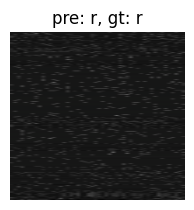

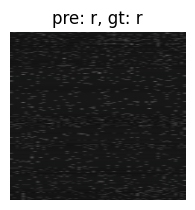

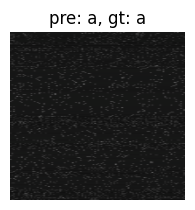

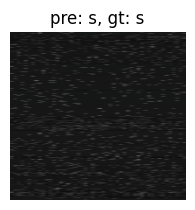

In [30]:
# results visualization
visualize_model(model_ft, num_images=4)